In [1]:
import torch
import urllib.request
from time import time
from transformers import AutoModelForVision2Seq, AutoProcessor
from PIL import Image
from io import BytesIO
from pathlib import Path

def read_image(path_or_url: str) -> Image:
    """
    Read an image from a file path or URL.

    Parameters
    ----------
    path_or_url : str
        The path or URL to the image.

    Returns
    -------
    Image
        The image.
    """
    if Path(path_or_url).is_file():
        return Image.open(path_or_url)

    try:
        with urllib.request.urlopen(path_or_url) as response:
            image_data = response.read()
        return Image.open(BytesIO(image_data))
    except Exception:
        raise ValueError("Invalid path or URL provided.")

def inference(
    processor: AutoProcessor,
    model: AutoModelForVision2Seq,
    image: Image,
    num_beams: int = 4,
    device: str = None,
) -> str:
    """
    Perform inference on an image and generate a caption.

    Parameters
    ----------
    processor : AutoProcessor
        The processor to preprocess the image.
    model : AutoModelForVision2Seq
        The model to generate the caption.
    image : Image
        The image to generate the caption for.
    num_beams : int, optional
        The number of beams to use in beam search, by default 4.
    device : str, optional
        The device to use, by default "cuda".

    Returns
    -------
    str
        The generated caption.
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    start_time = time()
    outputs = processor(
        images=image,
        return_tensors="pt",
    )
    outputs = {k: v.to(device.lower()) for k, v in outputs.items()}
    logits = model.generate(
        **outputs,
        max_length=128,
        num_beams=num_beams,
    )
    caption = processor.decode(
        logits[0], skip_special_tokens=True
    )
    end_time = time()

    caption = caption.capitalize() + "."
    inference_time = round(end_time - start_time, 2)
    return caption, inference_time

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = AutoModelForVision2Seq.from_pretrained("tanthinhdt/blip-base_with-pretrained_flickr30k")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/765 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

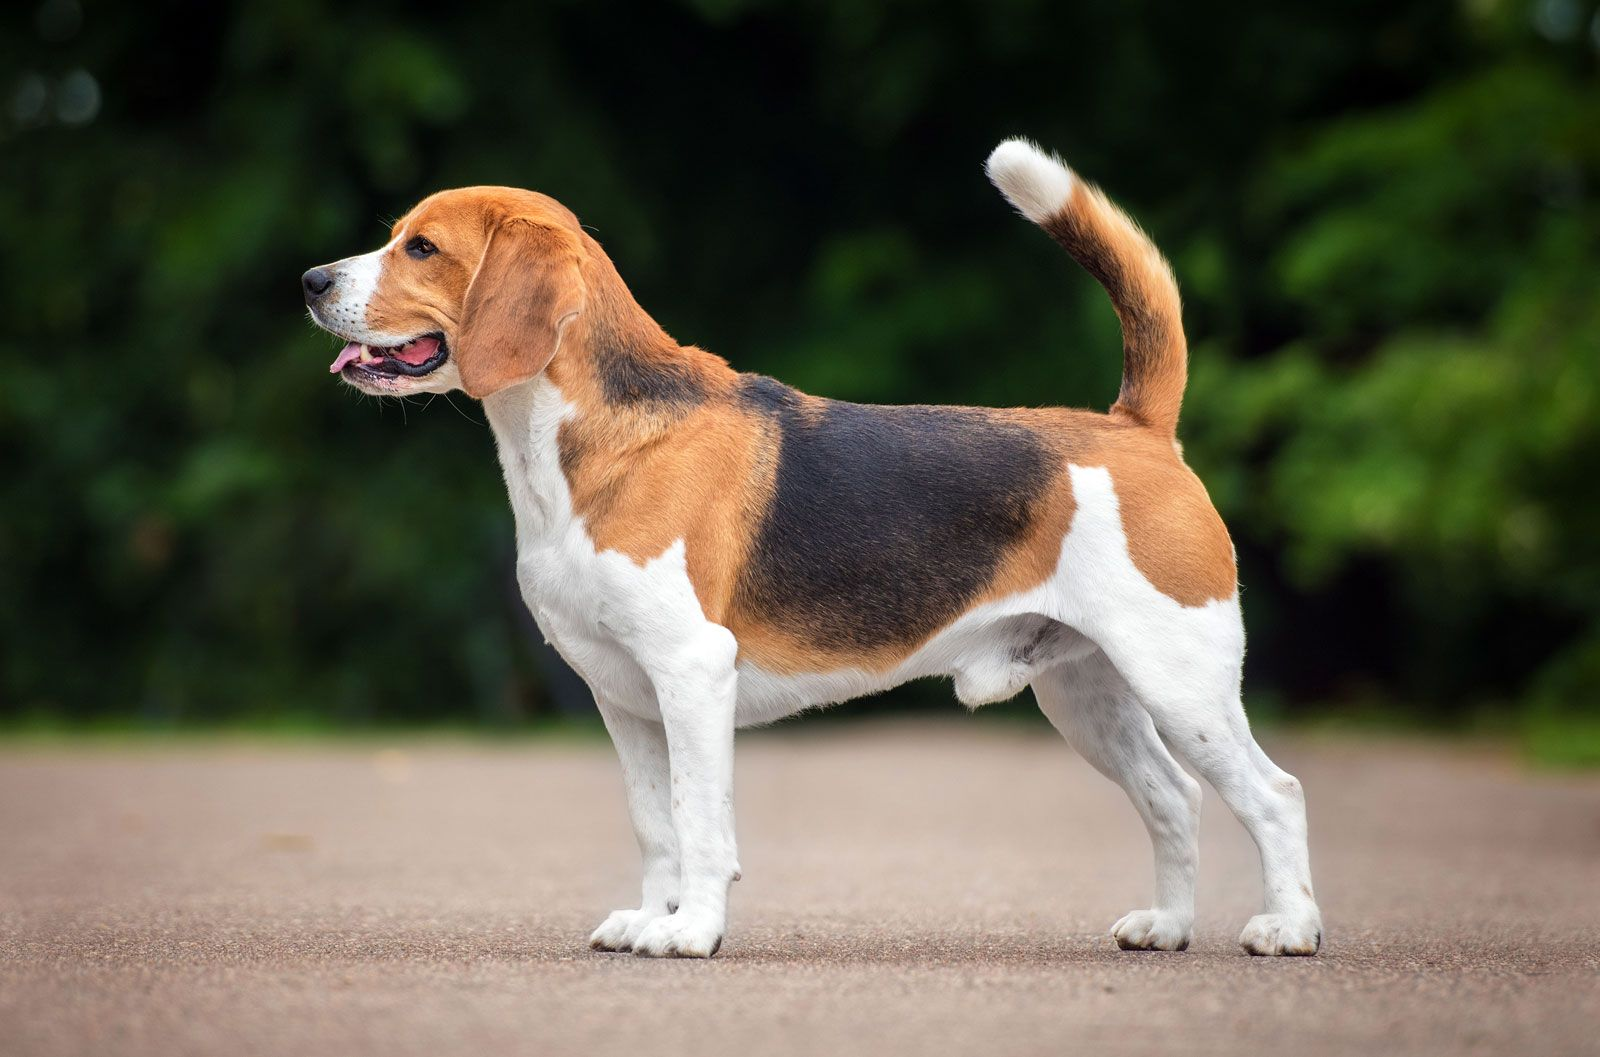

Caption: A brown and white dog standing on a road with trees in the background.
Inference time: 2.87 seconds


In [2]:
image_path_or_url = "https://cdn.britannica.com/16/234216-050-C66F8665/beagle-hound-dog.jpg"
num_beams = 4

image = read_image(image_path_or_url)
display(image)
caption, inference_time = inference(processor, model, image, num_beams)
print(f"Caption: {caption}")
print(f"Inference time: {inference_time} seconds")